# Monte Carlo Simulation Python


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import norm



# Set timeframe #


In [2]:
years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365 * years)

## Create Tickers ##


In [3]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

In [4]:
adj_close_priceDF = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate, auto_adjust = False)
    adj_close_priceDF[ticker] = data['Adj Close']

print(adj_close_priceDF)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2010-04-29   91.843842  51.808941  114.279999   43.855530   47.310802
2010-04-30   90.286003  51.958683  115.360001   42.991154   46.501289
2010-05-03   91.456276  51.930580  115.730003   43.593597   47.127518
2010-05-04   89.305710  52.080780  114.870003   42.283943   45.981983
2010-05-05   88.773766  52.106895  115.089996   42.065659   45.607773
...                ...        ...         ...         ...         ...
2025-04-17  526.409973  72.650002  306.119995  444.100006  258.750000
2025-04-21  513.880005  72.250000  315.589996  433.109985  252.600006
2025-04-22  527.250000  72.379997  311.109985  444.480011  259.029999
2025-04-23  535.419983  72.529999  303.649994  454.559998  263.440002
2025-04-24  546.690002  72.940002  308.070007  467.350006  268.989990

[3771 rows x 5 columns]


### Calculate daily log returns ###

In [5]:
#taking the log of the previous daily close price shifted. Meaning we log the row above the current day
log_returns  = np.log(adj_close_priceDF / adj_close_priceDF.shift(1))
log_returns = log_returns.dropna()

#print
log_returns

,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2010-04-30,-0.017107,0.002886,0.009406,-0.019906,-0.017259
2010-05-03,0.012879,-0.000541,0.003202,0.013916,0.013377
2010-05-04,-0.023796,0.002888,-0.007459,-0.030503,-0.024607
2010-05-05,-0.005974,0.000501,0.001913,-0.005176,-0.008171
2010-05-06,-0.033778,0.003878,0.029114,-0.033987,-0.034237
...,...,...,...,...,...
2025-04-17,0.001426,-0.002200,-0.004400,-0.000180,0.002089
2025-04-21,-0.024091,-0.005521,0.030467,-0.025058,-0.024055
2025-04-22,0.025685,0.001798,-0.014297,0.025913,0.025137


## Calculate Portfolio Expected Return ##

In [6]:
#The following function takes the log_returns dataframe and computes the expected return 
#by calculating the mean for each index over the 15 year time frame
#and then multiple by each of their weights respectively
#Lastly we sum all to find the portfolios TOTAL expected returns

##Disclaimer: Assume future returns are based on past returns in this model

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights)


In [7]:
#Calculate Variance
#Transpose the weights matrix and multiply by the covariance matrix, 
#then multiply by original weights array
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @weights
    #std.dev is the sqrt of the variance
    return np.sqrt(variance)

## Create a covariance matrix for all securities ##

In [8]:
cov_matrix = log_returns.cov()

cov_matrix

,SPY,BND,GLD,QQQ,VTI
SPY,1.218496e-04,3.999713e-07,0.000005,0.000136,1.241657e-04
BND,3.999713e-07,9.529765e-06,0.000009,0.000001,5.938153e-07
GLD,5.456445e-06,9.034327e-06,0.000096,0.000007,5.986275e-06
QQQ,1.360318e-04,1.201627e-06,0.000007,0.000175,1.386448e-04
VTI,1.241657e-04,5.938153e-07,0.000006,0.000139,1.275132e-04


## Create Equally Weighted Portfolio (Hypothetical Numbers)

In [9]:
portfolio_value = 1000000

#Assuming a total portfolio of 1 million dollars, and equally weighted securities
weights = np.array([1 / len(tickers)] * len(tickers))
portfolio_expected_return = expected_return(weights, log_returns)
portfolio_std_dev = standard_deviation(weights, cov_matrix)

## Calculate a random Z-Score for a normal distribution ##

In [10]:
def random_z_score():
    return np.random.normal(0,1)

## Calculate Scenario Gains/Losses over a 5 day "What If" period

In [11]:
# If in the next 5 days, at the 95% confidence interval, 
# what is the 5th percentile worst day scenario?
# Meaning how much money could we possibly lose?

# The following would give the TOTAL expected return over the time period
# >>portfolio_value * portfolio_expected_return * days

# The following will add a volatile element, meaning a negative 
# or positive variance depending on the z-score
# >> portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

days = 5

def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

## Run 10,000 simulations ##

In [12]:
# 10,000 - 20,000 simulations will produce more accurate results
# Given the amount of data we are testing this amount of simulations is appropriate
# Shorter data sets can get away 300-500 simulations

simulations = 10000
scenarioReturn = []

#Pass results into empty array
for i in range(simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days))
    

## Value at Risk ##

## Set the Confidence Interval ##

In [15]:
confidence_interval = 0.95
# 1 - confidence interval is the significance level
VaR = -np.percentile(scenarioReturn, 100 * (1 - confidence_interval))
print(VaR)

25608.00117119169


## Plot Results of Simulation ##

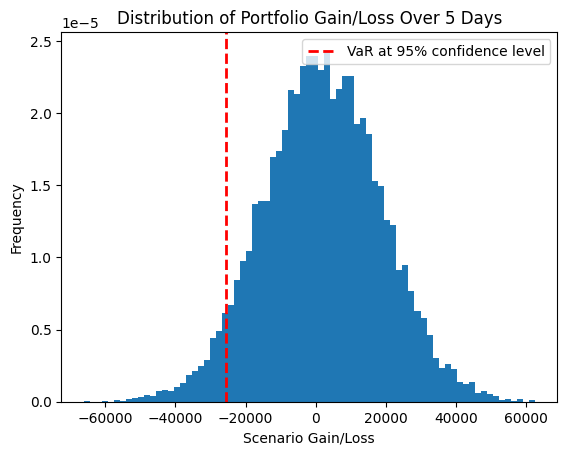

In [16]:
plt.hist(scenarioReturn, bins = 75, density = True)
plt.xlabel('Scenario Gain/Loss')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio Gain/Loss Over {days} Days')
plt.axvline(-VaR, color = 'r', linestyle = 'dashed', linewidth = 2, label = f'VaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()

### Monte Carlo Simulation Results and Analysis

The graph above displays the projected range of portfolio gains and losses over a hypothetical 5-day period, based on 10,000 Monte Carlo simulation trials.  
Each simulation models possible short-term returns using 15 years of historical price data for SPY, BND, GLD, QQQ, and VTI to estimate volatility and expected retur
At a 95% confidence interval, our Monte Carlo simulation estimates that the portfolio's Value at Risk (VaR) over a 5-day period is approximately -25000, meaning there is a 5% chance of experiencing losses greater than $25,000.
ns.